# **Resume Information Extraction**

This notebook demonstrates a process to extract structured information from resume PDF files. The key steps covered are:

1.  **Getting the Data**: Downloading the resume dataset.
2.  **Data Preprocessing**: Converting PDFs to images and applying image processing techniques like grayscale conversion, noise reduction, sharpening, and binarization.
3.  **Text Extraction**: Using Tesseract OCR to extract text from the processed images.
4.  **Information Extraction**: Utilizing the Gemini model to extract structured data (e.g., title, summary, experience) based on the images and extracted text.
5.  **Generating Output**: Displaying the extracted information alongside the original images.

This notebook provides a practical example of combining image processing, OCR, and large language models for information extraction from documents.

## **Getting the Data**

https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset/data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'resume-dataset' dataset.
Path to dataset files: /kaggle/input/resume-dataset


# **Data Preprocessing**

The data that we downloaded is in the form of pdfs which we need to convert into images.

We'll play with one file first.

In [2]:
import os
one_file_path = os.path.join(path, 'data', 'data', 'DESIGNER', '10466583.pdf')

In [3]:
open(one_file_path)

<_io.TextIOWrapper name='/kaggle/input/resume-dataset/data/data/DESIGNER/10466583.pdf' mode='r' encoding='utf-8'>

### **PDF to Image**

In [4]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 80.8 MB/s eta 0:00:00


In [5]:
import fitz

def convert_pdf_to_image(pdf_path, output_dir):

  os.makedirs(output_dir, exist_ok=True)

  try:
      doc = fitz.open(pdf_path)
      # Convert only the first page (page_num = 0)
      page = doc.load_page(0)
      pix = page.get_pixmap()
      original_filename = os.path.basename(pdf_path)
      filename_without_ext = os.path.splitext(original_filename)[0]
      output_filepath = os.path.join(output_dir, f"{filename_without_ext}.png")
      pix.save(output_filepath)
      print(f"Saved {output_filepath}")
      doc.close()
  except fitz.FileNotFoundError:
      print(f"Error: File not found at {pdf_path}")
  except Exception as e:
      print(f"An error occurred: {e}")

In [6]:
convert_pdf_to_image(one_file_path, "pdf_images")

Saved pdf_images/10466583.png


### Let's display the saved image...

In [7]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_image(image, title="Image"):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

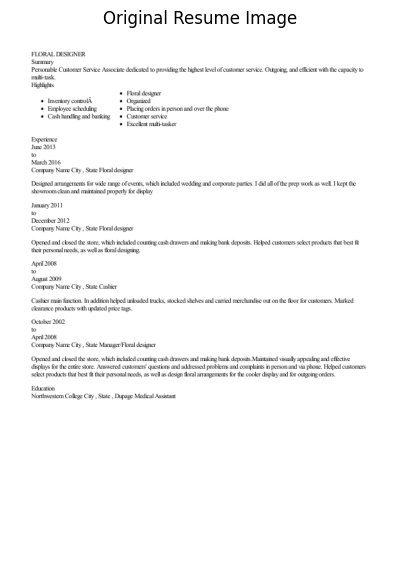

In [8]:
one_image = cv2.imread('pdf_images/10466583.png')
display_image(one_image, "Original Resume Image")

### Now let's try some image pre-processing...

### **Grayscale Conversion**

In [9]:
# Convert the image to grayscale
def convert_to_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

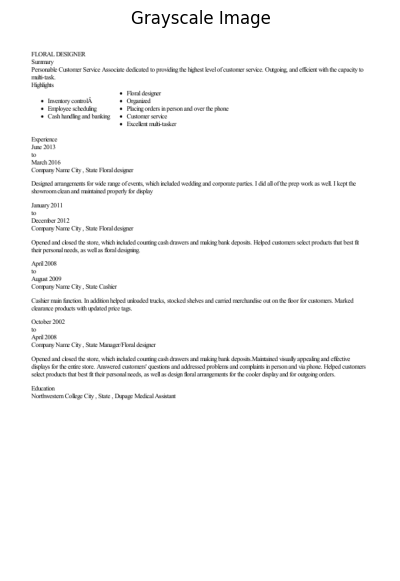

In [10]:
grayscale_image = convert_to_grayscale(one_image)
display_image(grayscale_image, "Grayscale Image")

### **Noise (blur) Reduction**

In [11]:
def reduce_noise(gray_image):
  return cv2.GaussianBlur(gray_image, (5, 5), 0)

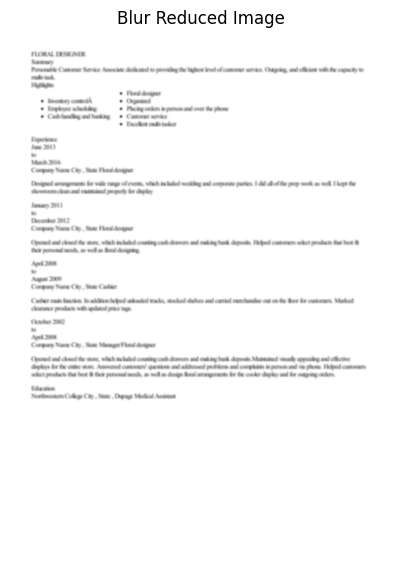

In [12]:
blur_reduced_image = reduce_noise(grayscale_image)
display_image(blur_reduced_image, "Blur Reduced Image")

### As observed, the blur reduction didn't help much instead blurred the image more, let's try sharpening the image...

In [13]:
import cv2
import numpy as np

def unsharp_masking(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):

    # Apply Gaussian blur to the image
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)

    # Calculate the sharpened image
    sharpened = float(amount + 1) * image - float(amount) * blurred

    # Clip the pixel values to be within the valid range [0, 255]
    sharpened = np.maximum(sharpened, 0)
    sharpened = np.minimum(sharpened, 255)
    sharpened = sharpened.astype(np.uint8)

    # Apply thresholding
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        sharpened[low_contrast_mask] = image[low_contrast_mask]

    return sharpened

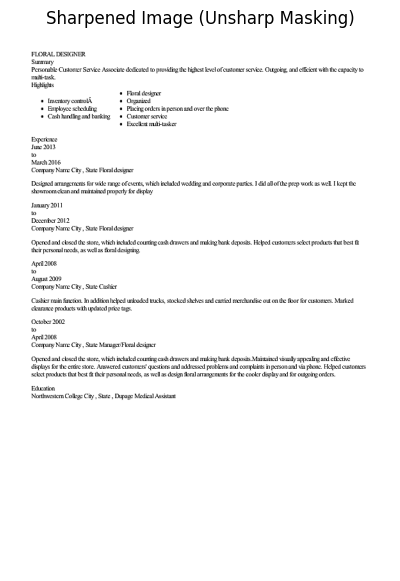

In [14]:
sharpened_image = unsharp_masking(grayscale_image)
display_image(sharpened_image, "Sharpened Image (Unsharp Masking)")

### Sharpened image seems to be bit better than the blur reduced image.

### Now let's binarize the images.





### **Binarization**

In [15]:
def binarize_image(blur_reduced_image):
  return cv2.adaptiveThreshold(
    blur_reduced_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, # Invert the colors (text becomes white)
    11, # Block size
    4  # Constant C
  )

### 1. Binarizing the sharpened image

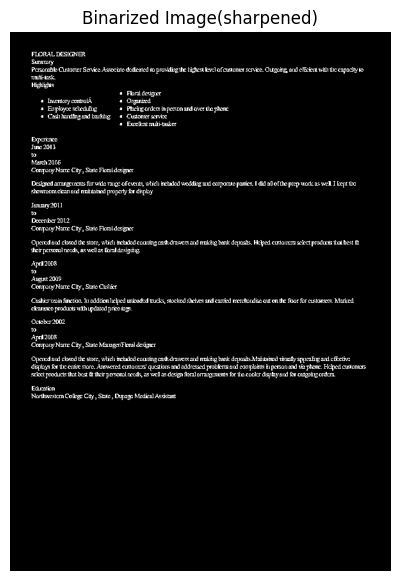

In [16]:
binarized_image_sharpened = binarize_image(sharpened_image)
display_image(binarized_image_sharpened, "Binarized Image(sharpened)")

### 2. Binarizing blur reduced image

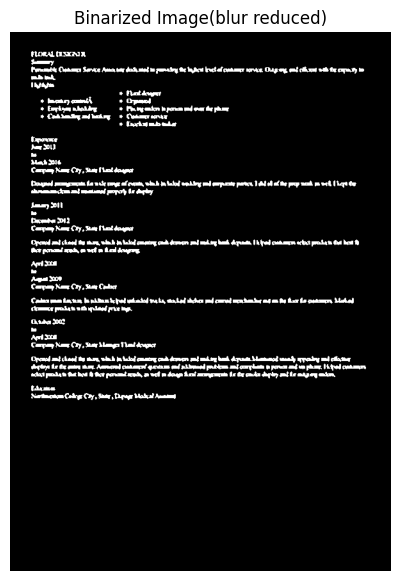

In [17]:
binarized_image_blur_reduced = binarize_image(blur_reduced_image)
display_image(binarized_image_blur_reduced, "Binarized Image(blur reduced)")

### 3. Binarizing grayscale image

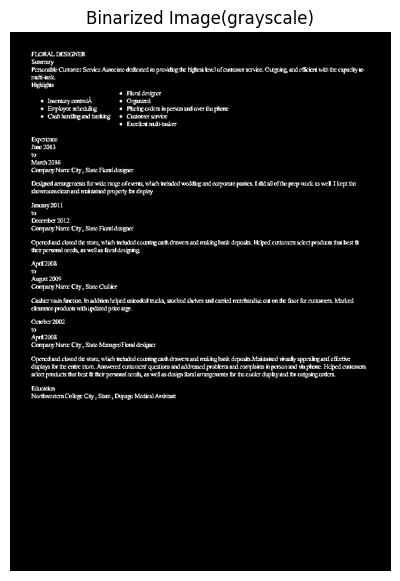

In [18]:
binarized_grayscale_image = binarize_image(grayscale_image)
display_image(binarized_grayscale_image, "Binarized Image(grayscale)")

###Somehow all three binarized images appear to have lost their clarity.

###For comaprison we'll still try to extract text from all these three images along with the actual grayscale image.

#  **Text Extraction: Tesseract**

In [19]:
!pip install pytesseract pillow

### 1. Text Extraction for Sharpened Binarized Image

In [20]:
from PIL import Image
import pytesseract


# Convert the NumPy array to a Pillow Image object
pil_image = Image.fromarray(binarized_image_sharpened)

text = pytesseract.image_to_string(pil_image)

print(text)

meine’
pony
Le ene en ete ee er eee eee
pare

coo
| onlassiner
ers ey
ee er
Seth ae err ee)
eeeeeens
Ce
pein
ad

See eed

De eae a eee ee eC oe Ee cece Bas
sucemeie rhe rearctin sae sehen

poeae)
eres
Lose eet ne eed

De Cte ee etn eset ney
peer ec

rd

rd
eee na ecnred

ee eee ere ee ee ered
Precekeceneserencrsrhsrl

Coed

Aged 2008

fea eee eed

Ce ee rer
Ferrers ee erent eee een arn etree ee neers
poser et ee eee Sot eee sere eed

cre
ee or eee’



### 2. Text Extraction for Blur Reduced Binarized Image.

In [21]:
pil_image = Image.fromarray(binarized_image_blur_reduced)

text = pytesseract.image_to_string(pil_image)

print(text)

Seren

—
L.->-7\neneidetne hen aheeeiacaiein abhieiemmeninatir aseinsalemetaneia
pi

ae
eer ad
 tmeaney cth, pron)
en SMR ie eal pant end
Pe racer og enn
pr renrewr
byerose
paso
reo

eh ioe lota ad

eslgaernen tactivetertar alert meet rite mer titard
penanderaadar miner jatar ire

atoll

ata}
eh oot ad

De er ete eene cote eto Deore ar iey
ete’

Apion

aired
eet onload

relent weakele ee aehe ene Crue Te ro in eter | WUT mat ye]
Pomme erred

rad

Parcel
ee neler

ee erly en Late Le cgeediat vty hertent oesie tamale loreal
ae eee rap myie pe aner ey aap er rr Mee
peeiciog erry Wpaaesrmarenhe ny nr pices aseny anlar ster rar ny

[rend
te nt tno



### 3. Text Extraction for Binarized Grayscale Image

In [22]:
pil_image = Image.fromarray(binarized_grayscale_image)

text = pytesseract.image_to_string(pil_image)

print(text)

nos

Samay
Ce Rs ee cee ee kete ete oe cate as
pares

co
« Rinassigee
ee ey
ee a ees
ers ree a ee
eae
Exper
pie

 

peed
Se mae

De eee Ce ce ee eee ene tert
poncenvin.sirerrtorcsa Sento

coeerny

ered
ey

Se a ee ete aS erst nto y
eter enn rece’

erry

rd
ote Caan

eee eee ete ee en et eed
peaelenerneserinersrnoeal

comer
Puc’

ee ed

Ce ee te ee ea ene end

Ener ey eee rene eon ee are eee ae eee nen
peseceteer ereer i sateeee nerve Pe ey aes ey eet cas eT eee

rere)
een ences



### 4. Text Extraction for Actual Grayscale Image

In [23]:
pil_image = Image.fromarray(grayscale_image)

text = pytesseract.image_to_string(pil_image)

print(text)

FLORAL DESIGNER
Summary
Posaable Customer Senie Asoc dicted to proving ese ofeusone sence. Ouguiya eset wih he capaci
mairesk.

Higgs
“+ onl desir
“merry cont + Onied
{ Enphyeeschsing + Phchgonkrsinpersonand over the phone
+ Cotbaningand barking + Custom seve
Evo maker
Experince
due 2013
March 2016

‘Conpany Name Cty, Stat Fla dsier

Designed arangens fr wile rang ove, wich intaed wedi nd coyporte parts illo the prep wok as We. pt tbe
stosoonckanand nai propa Be dy

Jnnsry2011
Davenber2012
‘Conpay Nane Chy, Stat Fal dsier

‘Opened ant ced he ste, wich cad coun cash drawers nl king nk depos Hp stoners sks prods tht est
ti prsona neds, as wollasHaldsigay

apea208

‘Ags 2000
‘Canpany Name Cy, Stat Cashier

(Casior sin fintbn. nation ped ube muss, socked shehes and cain! mechan ut nthe thr fr custome. Masked
bara prods wi pied prices.

Oeter 2002
‘Ape208
‘Conpany Name Cy, Stat Marner Fel desir

‘Opened ant ced he tor, wich cad courting cash ravers al king nk deposits Mts val pag an efctne


### From all the above four results, we can see that the actual grayscale image gives the best result for text extraction, so we'll continue with that.

## **Applying preprocessing to Other PDFs**

In [24]:
def preprocess_pdf(pdf_path, image_dir, processed_image_dir):

  if not os.path.exists(image_dir):
    os.makedirs(image_dir)

  if not os.path.exists(processed_image_dir):
    os.makedirs(processed_image_dir)

  convert_pdf_to_image(pdf_path, image_dir)

  for filename in os.listdir(image_dir):
    if filename.endswith(".png"):
      image_path = os.path.join(image_dir, filename)
      image = cv2.imread(image_path)
      grayscale_image = convert_to_grayscale(image)

      # Save the grayscale image to the processed_image_dir
      original_filename = os.path.basename(image_path)
      output_filepath = os.path.join(processed_image_dir, original_filename)
      cv2.imwrite(output_filepath, grayscale_image)
      print(f"Saved processed image to: {output_filepath}")

We are doing preprocessing for final five resume for which we will be extracting data.

In [25]:
image_dir = "pdf_images"
processed_image_dir = "processed_images"

file_path1 = os.path.join(path, 'data', 'data', 'TEACHER', '37402097.pdf')
file_path2 = os.path.join(path, 'data', 'data', 'ENGINEERING', '21629057.pdf')
file_path3 = os.path.join(path, 'data', 'data', 'CONSULTANT', '38399177.pdf')
file_path4 = os.path.join(path, 'data', 'data', 'CHEF', '91072502.pdf')
file_path5 = os.path.join(path, 'data', 'data', 'ADVOCATE', '10344379.pdf')

preprocess_pdf(file_path1, image_dir, processed_image_dir)
preprocess_pdf(file_path2, image_dir, processed_image_dir)
preprocess_pdf(file_path3, image_dir, processed_image_dir)
preprocess_pdf(file_path4, image_dir, processed_image_dir)
preprocess_pdf(file_path5, image_dir, processed_image_dir)

Saved pdf_images/37402097.png
Saved processed image to: processed_images/10466583.png
Saved processed image to: processed_images/37402097.png
Saved pdf_images/21629057.png
Saved processed image to: processed_images/21629057.png
Saved processed image to: processed_images/10466583.png
Saved processed image to: processed_images/37402097.png
Saved pdf_images/38399177.png
Saved processed image to: processed_images/38399177.png
Saved processed image to: processed_images/21629057.png
Saved processed image to: processed_images/10466583.png
Saved processed image to: processed_images/37402097.png
Saved pdf_images/91072502.png
Saved processed image to: processed_images/38399177.png
Saved processed image to: processed_images/91072502.png
Saved processed image to: processed_images/21629057.png
Saved processed image to: processed_images/10466583.png
Saved processed image to: processed_images/37402097.png
Saved pdf_images/10344379.png
Saved processed image to: processed_images/38399177.png
Saved proc

Using tesseract for these resume...

In [26]:
from PIL import Image
import pytesseract
import time
import os # Import os module

input_folder_path = "/content/processed_images"
output_folder_path = "/content/tesseract_output"
start_time = time.time()

os.makedirs(output_folder_path, exist_ok=True) # Removed the print statement here

total_images = sum(1 for entry in os.scandir(input_folder_path) if entry.is_file()) # Count only files
print(f"Total images in folder: {total_images}")

# Iterate through entries and process only files
for i, entry in enumerate(os.scandir(input_folder_path), 1):
  if entry.is_file(): # Check if the entry is a file
    image_name = entry.name
    print(f"Processing image {i}/{total_images}: {image_name}")
    image_path = entry.path # Use entry.path to get the full path
    print("Extracting text from image..")
    text = pytesseract.image_to_string(Image.open(image_path))
    output_path = os.path.join(output_folder_path, image_name.replace(".png", ".txt"))
    with open(output_path, "w") as f:
      f.write(text)

    print(f"Saved extracted text to {output_path}")
    print("-"*50)

print("Text Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 6
Processing image 1/6: 38399177.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/38399177.txt
--------------------------------------------------
Processing image 2/6: 91072502.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/91072502.txt
--------------------------------------------------
Processing image 3/6: 21629057.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/21629057.txt
--------------------------------------------------
Processing image 4/6: 10466583.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/10466583.txt
--------------------------------------------------
Processing image 5/6: 10344379.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/10344379.txt
--------------------------------------------------
Processing image 6/6: 37402097.png
Extracting text from image..
Saved extracted text

### **Information Extraction**

In [27]:
prompt = """
Extract the information from the given image.
Information to be extracted: title, summary, current organization, experience, education, skills
The image has been converted to grayscale using opencv.
Always give your response in the following format:
{
    "title": "TITLE",
    "summary": "SUMMARY",
    "current_organization": "CURRENT ORGANIZATION",
    "experience": "EXPERIENCE",
    "education": "EDUCATION",
    "skills": "SKILLS
}
Also, the text has been extracted from the image using tesseract.
Use the extracted text as support for extracting information.
If you believe the extraction is incorrect somewhere, you may correct it yourself and provide corrected information.
Respond with the extracted information only in the specified format.
Here is the text:


"""

In [28]:
from google import genai
from google.colab import userdata # colab only code
from PIL import Image
import json
import time

In [30]:
genai_client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

In [31]:
image_folder_path = "/content/processed_images"
text_folder_path = "/content/tesseract_output"
output_folder_path = "/content/json_output"

start_time = time.time()

os.makedirs(output_folder_path, exist_ok=True)
print(f"Created folder: {output_folder_path}")

# Count only files in the image folder
total_images = sum(1 for entry in os.scandir(image_folder_path) if entry.is_file())
print(f"Total images in folder: {total_images}")

# Iterate through entries and process only files
for i, entry in enumerate(os.scandir(image_folder_path), 1):
  if entry.is_file(): # Check if the entry is a file
    image_name = entry.name
    print(f"Processing image {i}/{total_images}: {image_name}")
    image_path = entry.path # Use entry.path to get the full path
    print(f"Loading image: {image_path}")
    with open(image_path, "rb") as f:
      image = Image.open(image_path)


    text_path = os.path.join(text_folder_path, image_name.replace(".png", ".txt"))
    print(f"Loading extracted text: {text_path}")
    # Check if the corresponding text file exists before opening
    if os.path.exists(text_path):
        with open(text_path, "r") as f:
          text = f.read()
    else:
        print(f"Warning: Text file not found for {image_name}. Skipping information extraction for this image.")
        continue # Skip to the next image

    print("Extracting information from image and text..")

    current_prompt = prompt + text # Use a different variable name to avoid modifying the original prompt string


    contents = [
          image,
          {
              "text": current_prompt
          }
      ]
    response = genai_client.models.generate_content(model='gemini-1.5-flash', contents=contents)

    # Access the usage_metadata attribute
    usage_metadata = response.usage_metadata

    # Print the different token counts
    print(f"Input Token Count: {usage_metadata.prompt_token_count}")
    print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
    print(f"Output Token Count: {usage_metadata.candidates_token_count}")
    print(f"Total Token Count: {usage_metadata.total_token_count}")

    extracted_information = json.loads(response.text.replace('```json', '').replace('```', ''))
    output_path = os.path.join(output_folder_path, image_name.replace(".png", ".json"))
    with open(output_path, "w") as f:
      json.dump(extracted_information, f, indent=4)

    print(f"Saved extracted information to {output_path}")
    print("-"*50)
    time.sleep(5) # Reduced sleep time for faster processing

print("Information Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Created folder: /content/json_output
Total images in folder: 6
Processing image 1/6: 38399177.png
Loading image: /content/processed_images/38399177.png
Loading extracted text: /content/tesseract_output/38399177.txt
Extracting information from image and text..
Input Token Count: 899
Thoughts Token Count: None
Output Token Count: 472
Total Token Count: 1371
Saved extracted information to /content/json_output/38399177.json
--------------------------------------------------
Processing image 2/6: 91072502.png
Loading image: /content/processed_images/91072502.png
Loading extracted text: /content/tesseract_output/91072502.txt
Extracting information from image and text..
Input Token Count: 1303
Thoughts Token Count: None
Output Token Count: 819
Total Token Count: 2122
Saved extracted information to /content/json_output/91072502.json
--------------------------------------------------
Processing image 3/6: 21629057.png
Loading image: /content/processed_images/21629057.png
Loading extracted text:

# **Generating Output**

Displaying information for: 38399177.png


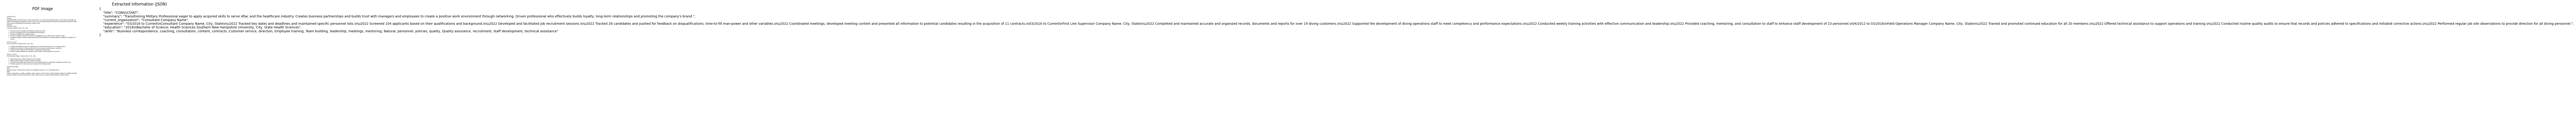

--------------------------------------------------
Displaying information for: 91072502.png


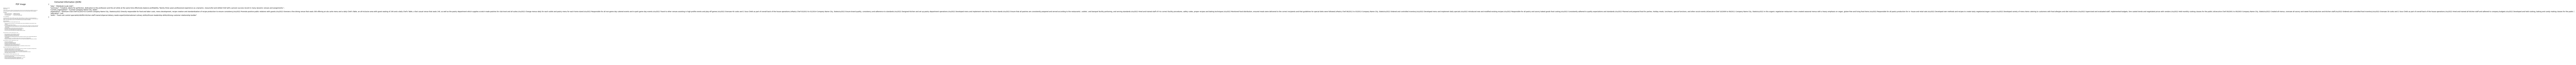

--------------------------------------------------
Displaying information for: 21629057.png


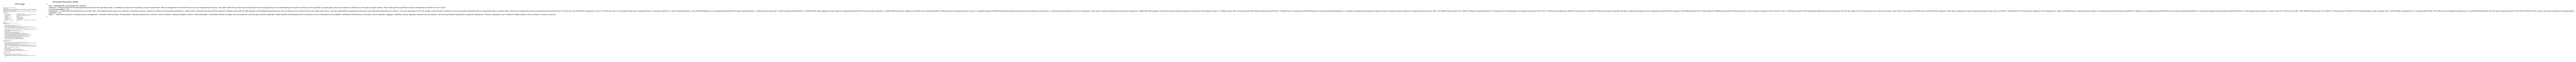

--------------------------------------------------
Displaying information for: 10466583.png


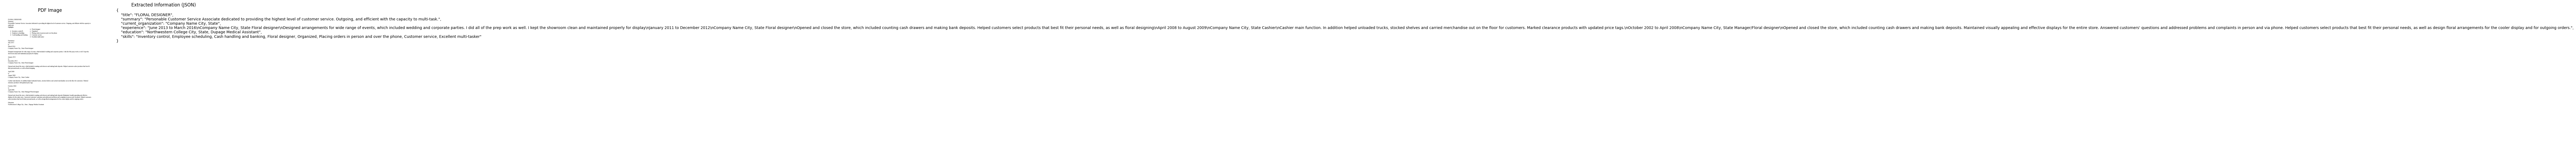

--------------------------------------------------
Displaying information for: 10344379.png


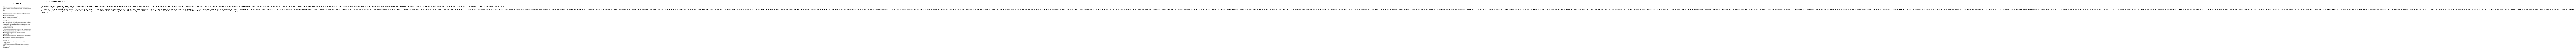

--------------------------------------------------
Displaying information for: 37402097.png


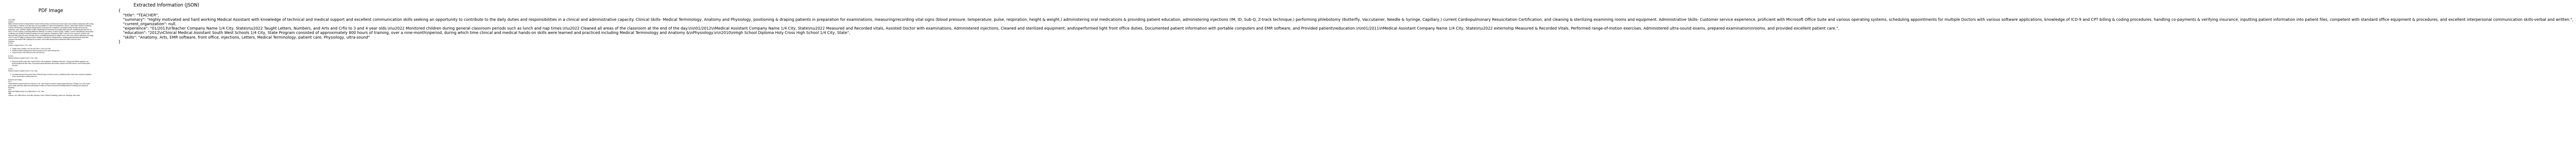

--------------------------------------------------


In [32]:
import os
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt

image_folder_path = "/content/pdf_images"
json_folder_path = "/content/json_output"

# Get a list of image files in the processed_images folder
image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.png')]

for image_name in image_files:
    image_path = os.path.join(image_folder_path, image_name)
    json_name = image_name.replace(".png", ".json")
    json_path = os.path.join(json_folder_path, json_name)

    if os.path.exists(json_path):
        print(f"Displaying information for: {image_name}")

        # Load and display the image
        image = cv2.imread(image_path)
        plt.figure(figsize=(10, 7)) # Adjust figure size as needed
        plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("PDF Image")
        plt.axis('off')

        # Load and display the JSON content
        with open(json_path, 'r') as f:
            extracted_data = json.load(f)

        plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
        plt.text(0, 1, json.dumps(extracted_data, indent=4), fontsize=10, va='top', ha='left')
        plt.title("Extracted Information (JSON)")
        plt.axis('off')

        plt.show()
        print("-" * 50)
    else:
        print(f"No JSON file found for {image_name}")

# Notebook Summary

This notebook demonstrates a workflow for extracting structured information from resume PDF files. The steps involved are:

1.  **Dataset Download**: Downloading the resume dataset from Kaggle.
2.  **PDF to Image Conversion**: Converting the PDF files into images using PyMuPDF.
3.  **Image Preprocessing**: Applying various image preprocessing techniques using OpenCV, including:
    *   Grayscale conversion
    *   Noise (blur) reduction using Gaussian blur
    *   Sharpening using unsharp masking
    *   Binarization using adaptive thresholding
4.  **Text Extraction**: Extracting text from the preprocessed images using Tesseract OCR.
5.  **Information Extraction**: Using the Gemini model to extract structured information (title, summary, experience, education, skills) from the images, supported by the text extracted by Tesseract.
6.  **Output Generation**: Displaying the original images alongside the extracted information in JSON format.

The notebook explores different preprocessing techniques and their impact on text extraction accuracy, ultimately using the grayscale image for the final text extraction before utilizing the Gemini model for information extraction.